In [82]:
# -*- coding: utf-8 -*-
import operator
import statistics
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [83]:
data = pd.read_csv('/home/vinhali/Desktop/classification/data/data.csv')

In [84]:
def histogramNeuronsInput(result):
    """ Generates histogram of input neurons """
    fig, ax = plt.subplots(figsize=(10,6))
    for i in range(len(result)):
        data = np.array(result[i])
        x=np.arange(len(data)) + i*6
        # draw averages
        ax.bar(x-0.2, data[:,0], color='C0', width=0.4)
        # draw std
        ax.bar(x+0.2, data[:,1], color='C1', width=0.4)
        # separation line
        #if i < len(result) - 1:
            #ax.axvline(4.75 + i*6, color='black')
    # turn off xticks
    ax.set_xticks([])
    ax.legend(labels=['Average', 'Standard deviation'])
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('C0')
    leg.legendHandles[1].set_color('C1')
    plt.title("Histogram: Average versus Standard Deviation")
    plt.ylabel('Consume')
    plt.xlabel('Number of elements (Every 5 is a new block)')

    return plt.show()

def histogramNeuronsOutput(result):
    """ Generates histogram of output neurons """
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, data in enumerate(result):
        x = np.arange(len(data)) + i*6
        bars = ax.bar(x, data, color=colors, width=0.4)
        if i == 0:
            for bar, label in zip(bars, labels):
                bar.set_label(label)
        #if i < len(result) - 1:
            # separation line after each part, but not after the last
            #ax.axvline(4.75 + i*6, color='black')
    ax.set_xticks([])
    ax.legend()
    ax.set_title("Histogram")
    ax.set_ylabel('Consume')
    ax.set_xlabel('Percent')
    plt.show()

In [85]:
def standardDeviation(data):
    """ Calculates standard deviation """
    return statistics.stdev(data)
       
def average(data):
    """ Calculates average """
    return statistics.mean(data)

def captureOcurrences(elements, n):
    """ Capture an X number of elements within a list """
    L = len(elements)
    return [elements[i: i+n] for i in range(0, L, n)]

In [86]:
def neuronsInput(elements):
    """ Generates input neuron modeling (5 averages, 5 standard deviations - Between 12 occurrences in a window of 60 readings) """
    result = []
    temp = []
    start = 0
    limit = 60
    size = int(len(elements))
    TargetDivision = int(size / 30)
    repetitions = 0
    five = 0

    while repetitions < TargetDivision:
        temp = []

        five += 1
        ocurrences = captureOcurrences(elements[start: limit],12)
        for i in ocurrences:
            m = average(i)
            sd = standardDeviation(i)
            temp.append([m,sd])

        result.append(temp)

        repetitions += 1
        limit += 10
        start += 10

    return result

def neuronsOutput(elements):
    """ Generates output neuron modeling (Histogram of the next 30 data readings) """
    result = []
    start = 61
    limit = 90
    size = int(len(elements))
    TargetDivision = int(size / 30)
    repetitions = 0

    while repetitions < TargetDivision:

        counter=collections.Counter(elements[start: limit])
        consumption0_20 = 0
        consumption20_40 = 0
        consumption40_60 = 0
        consumption60_80 = 0
        consumption80_100 = 0
        for key in counter:
            if key <= 20:
                consumption0_20 += int(counter[key])
            elif key > 20 and key < 40:
                consumption20_40 += int(counter[key])
            elif key > 40 and key < 60:
                consumption40_60 += int(counter[key])
            elif key > 60 and key < 80:
                consumption60_80 += int(counter[key])
            elif key > 80 and key < 100:
                consumption80_100 += int(counter[key])

        result.append([consumption0_20,consumption20_40,consumption40_60,consumption60_80,consumption80_100])

        repetitions += 1
        limit += 10
        start += 10

    return result

In [87]:
def binaryInput(data):
    """ I divided the values ​​of each column by the highest occurrence in the column """
    max_average = 0
    max_deviation = 0
    for j in range(len(data[0])):
        for i in range(len(data)):
            if data[i][j][0] > max_average:
                max_average = data[i][j][0]
            if data[i][j][1] > max_deviation:
                max_deviation = data[i][j][1]
        for p in range(len(data)):
            if max_average != 0:
                data[p][j][0] = round(data[p][j][0] / max_average, 3)
            if max_deviation != 0:
                data[p][j][1]  = round(data[p][j][1] / max_deviation, 3)
        max_average = 0
        max_deviation = 0
    return data

def binaryOutput(data):
    """ I divided the values ​​of each column by the highest occurrence in the column """
    max_consume = 0
    for j in range(len(data[0])):
        for i in range(len(data)):
            if data[i][j] > max_consume:
                max_consume = data[i][j]
        for p in range(len(data)):
            if max_consume != 0:
                data[p][j] = round(data[p][j] / max_consume, 3)
        max_consume = 0
    return data

In [88]:
def conversionDataframe(dataNeuronInput,dataNeuronOutput):
    """ Converts data to a dataframe pandas """
    ni = pd.DataFrame(data= dataNeuronInput)
    ni.columns = ['m1,d1', 'm2,d2', 'm3,d3', 'm4,d4', 'm5,d5']

    no = pd.DataFrame(data= dataNeuronOutput)
    no.columns = ['0-20', '20-40', '40-60', '60-80', '80-100']

    return pd.concat([ni, no], axis=1)

In [89]:
def modeling(data):
    """ Generates the initial model for training the neural network """
    readings = data.iloc[:, 1].values

    dataNeuronInput = neuronsInput(readings)
    dataNeuronOutput = neuronsOutput(readings)
    dataFrameNoBinary = conversionDataframe(dataNeuronInput, dataNeuronOutput)
    binaryNeuronInput = binaryInput(dataNeuronInput)
    binaryNeuronOutput = binaryOutput(dataNeuronOutput)
    dataFrameBinary = conversionDataframe(binaryNeuronInput, binaryNeuronOutput)

    return dataFrameBinary

### View histogram

In [90]:
readings = data.iloc[:, 1].values

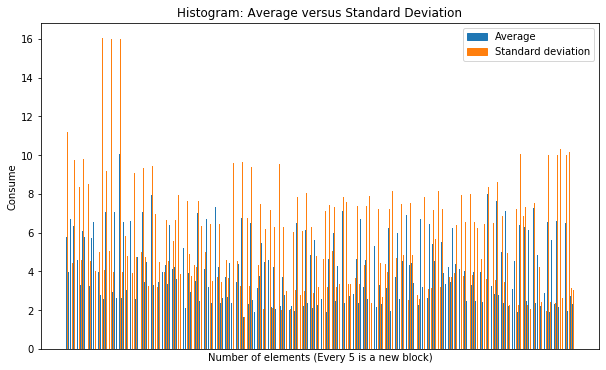

In [91]:
dataNeuronInput = neuronsInput(readings)
histogramNeuronsInput(dataNeuronInput)

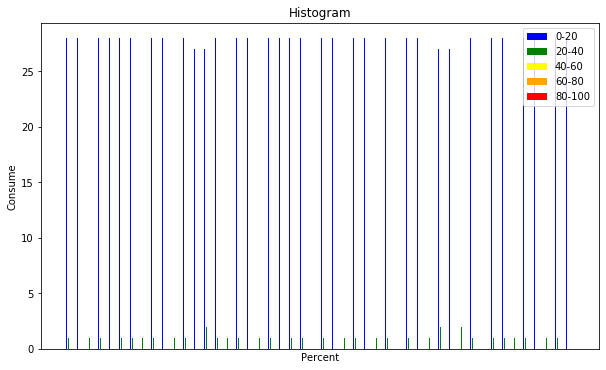

In [92]:
dataNeuronOutput = neuronsOutput(readings)
histogramNeuronsOutput(dataNeuronOutput)

### Execute script

In [93]:
df = modeling(data)

# only taking 'mi' and 'di' inputs for simplicity
ndf = df.to_numpy()[:, :5]

# ndf matrix contains python lists, it must be broken into floats
temp = []
for a in ndf:
    for b in a:
        temp.append(b)
ndf = (np.array(temp)).reshape((48, 10))

# Converting data matrix in such a form that we are given an input of i'th 
# time, and have to predict for (i+1)'th time
X = np.array([ndf[i, :] for i in range(0, ndf.shape[0]-1)])
y = np.array([ndf[i, :] for i in range(1, ndf.shape[0])])

In [94]:
print(X)

[[0.573 0.699 0.412 0.224 0.696 0.512 0.326 0.314 0.79  0.685]
 [0.456 0.251 0.629 0.523 0.344 0.286 0.8   0.699 0.721 1.   ]
 [0.658 0.531 0.339 0.282 0.592 0.614 0.859 1.    0.365 0.283]
 [0.396 0.314 0.29  0.201 1.    1.    0.34  0.288 0.886 0.647]
 [0.379 0.315 1.    1.    0.302 0.248 0.929 0.655 0.328 0.308]
 [1.    1.    0.274 0.249 0.679 0.536 0.52  0.413 0.382 0.337]
 [0.657 0.898 0.324 0.244 0.796 0.565 0.336 0.337 0.594 0.48 ]
 [0.397 0.312 0.731 0.583 0.358 0.296 0.586 0.495 0.263 0.228]
 [0.792 0.589 0.343 0.296 0.472 0.434 0.278 0.227 0.432 0.316]
 [0.395 0.366 0.301 0.247 0.449 0.413 0.438 0.324 0.798 0.545]
 [0.411 0.347 0.436 0.417 0.373 0.276 0.78  0.565 0.399 0.274]
 [0.521 0.443 0.221 0.206 0.658 0.476 0.512 0.35  0.364 0.264]
 [0.277 0.271 0.364 0.264 0.729 0.477 0.325 0.265 0.544 0.447]
 [0.409 0.312 0.693 0.484 0.333 0.234 0.551 0.458 0.297 0.246]
 [0.728 0.487 0.332 0.233 0.439 0.403 0.309 0.245 0.327 0.231]
 [0.368 0.287 0.279 0.229 0.46  0.396 0.309 0.235 0.854

In [95]:
print(y)

[[0.456 0.251 0.629 0.523 0.344 0.286 0.8   0.699 0.721 1.   ]
 [0.658 0.531 0.339 0.282 0.592 0.614 0.859 1.    0.365 0.283]
 [0.396 0.314 0.29  0.201 1.    1.    0.34  0.288 0.886 0.647]
 [0.379 0.315 1.    1.    0.302 0.248 0.929 0.655 0.328 0.308]
 [1.    1.    0.274 0.249 0.679 0.536 0.52  0.413 0.382 0.337]
 [0.657 0.898 0.324 0.244 0.796 0.565 0.336 0.337 0.594 0.48 ]
 [0.397 0.312 0.731 0.583 0.358 0.296 0.586 0.495 0.263 0.228]
 [0.792 0.589 0.343 0.296 0.472 0.434 0.278 0.227 0.432 0.316]
 [0.395 0.366 0.301 0.247 0.449 0.413 0.438 0.324 0.798 0.545]
 [0.411 0.347 0.436 0.417 0.373 0.276 0.78  0.565 0.399 0.274]
 [0.521 0.443 0.221 0.206 0.658 0.476 0.512 0.35  0.364 0.264]
 [0.277 0.271 0.364 0.264 0.729 0.477 0.325 0.265 0.544 0.447]
 [0.409 0.312 0.693 0.484 0.333 0.234 0.551 0.458 0.297 0.246]
 [0.728 0.487 0.332 0.233 0.439 0.403 0.309 0.245 0.327 0.231]
 [0.368 0.287 0.279 0.229 0.46  0.396 0.309 0.235 0.854 0.675]
 [0.342 0.283 0.454 0.397 0.268 0.203 0.888 0.685 0.208

In [96]:
X.shape, y.shape

((47, 10), (47, 10))

In [99]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [   
        # First layer of a sequential model must contain a input_shape
        # that defines the features
        layers.Dense(2, activation="relu", name="layer1", input_shape=X.shape[1:]),
        layers.Dense(3, activation="relu", name="layer2"),
        # The last layer of a sequential model should be equal to the number of
        # outputs, in this case : 5*2 = 10  (5 [mi, di] pairs)
        layers.Dense(10, name="layer3"),
    ]
)

# Compile the model and define a loss function (loss function generates 
# penalty for a wrong output)
model.compile(optimizer = 'Adam', loss = 'mse', metrics = ['mae'])
#model.compile(loss='mse')
# Check the architecture of the model (you may skip this line)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 2)                 22        
_________________________________________________________________
layer2 (Dense)               (None, 3)                 9         
_________________________________________________________________
layer3 (Dense)               (None, 10)                40        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [100]:
# The training
model.fit(X, y, batch_size=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1848 - mae: 0.3744
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1655 - mae: 0.3447
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1472 - mae: 0.3135
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1302 - mae: 0.2849
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1149 - mae: 0.2612
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1028 - mae: 0.2445
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0933 - mae: 0.2333
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0850 - mae: 0.2233
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0779 - mae: 0.2142
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0718 - mae: 0.2056
